# A two-stage cyber attack detection and classification system for smart grids
https://www.sciencedirect.com/science/article/pii/S2542660523002494#b47

## Methodology
- Read all DNP3 parsed data. i.e. unbalanced
- Make two copies i.e. one for attack detection (attack vs bengin) another for attack classification (only contains attack data)
- For each copies, perform random oversampling to handle class imbalance.
- Perform Recursive Feature Elimination (RFE) to get 13 features from 96. Use Random Forest Classifier to do so.
- Train RF, LR, DT, GNB, XGB for both steps.

### Read Data
- First copy all CSV files into a local folder to make it easier to run.


In [35]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from loguru import logger

In [36]:
def load_csv_files(all_files: list[Path]) -> pd.DataFrame:
    """
    Load all CSV files into a single DataFrame.
    """
    if len(all_files) == 0:
        logger.warning("No CSV files found.")
        return pd.DataFrame()
    dataframes = []
    for file in all_files:
        logger.info(f"Loading {file}")

        df = pd.read_csv(file, low_memory=False)
        if "Label" in df.columns:
            if "No Label" in df["Label"].unique():
                del df["Label"]
        df.columns = [c.strip() for c in df.columns]
        dataframes.append(df)
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df


data_root = Path(r"E:\MSc Works\IDS\data\Custom_DNP3_Parser")
logger.info(f"Data root: {data_root}")
all_files = list(data_root.glob("*.csv"))
logger.info(f"Found {len(all_files)} files in {data_root}")

combined_df = load_csv_files(all_files)
logger.info(f"Combined DataFrame shape: {combined_df.shape}")

2025-05-18 17:46:24.021 | INFO     | __main__:<module>:23 - Data root: E:\MSc Works\IDS\data\Custom_DNP3_Parser
2025-05-18 17:46:24.029 | INFO     | __main__:<module>:25 - Found 71 files in E:\MSc Works\IDS\data\Custom_DNP3_Parser
2025-05-18 17:46:24.030 | INFO     | __main__:load_csv_files:10 - Loading E:\MSc Works\IDS\data\Custom_DNP3_Parser\20200508_DNP3_Disable_Unsolicited_Messages_Attack_UOWM_DNP3_Dataset_Slave_05.pcapDNP3_FLOWLABELED.csv
2025-05-18 17:46:24.089 | INFO     | __main__:load_csv_files:10 - Loading E:\MSc Works\IDS\data\Custom_DNP3_Parser\20200514_Disable_Unsolicited_Messages_Attack_UOWM_DNP3_Dataset_Attacker_01.pcapDNP3_FLOWLABELED.csv
2025-05-18 17:46:24.139 | INFO     | __main__:load_csv_files:10 - Loading E:\MSc Works\IDS\data\Custom_DNP3_Parser\20200514_Disable_Unsolicited_Messages_Attack_UOWM_DNP3_Dataset_Attacker_02.pcapDNP3_FLOWLABELED.csv
2025-05-18 17:46:24.193 | INFO     | __main__:load_csv_files:10 - Loading E:\MSc Works\IDS\data\Custom_DNP3_Parser\2020051

#### Convert `firstPacketDIR` to binary
- 1 if Master 0 otherwise

In [37]:
combined_df.firstPacketDIR.value_counts()

firstPacketDIR
MASTER        31878
OUTSTATION     8542
Name: count, dtype: int64

In [38]:
combined_df.firstPacketDIR = combined_df["firstPacketDIR"].apply(
    lambda x: 1 if x == "MASTER" else 0
)
combined_df.firstPacketDIR.value_counts()

firstPacketDIR
1    31878
0     8542
Name: count, dtype: int64

In [39]:
combined_df.protocol.value_counts()

protocol
6    40420
Name: count, dtype: int64

### Remove Unwanted Features

In [40]:
ignore_columns = [
    "File",
    "flow ID",
    "binary_label",
    "Timestamp",
    "source IP",
    "destination IP",
    "date",
    "Unnamed: 0",
    "Unnamed: 0.1",
]
combined_df = combined_df[[c for c in combined_df.columns if c not in ignore_columns]]

### Clone and oversample

In [41]:
def oversample_class(df: pd.DataFrame, label: str) -> pd.DataFrame:
    """
    Oversample the specified class in the DataFrame.
    """
    logger.info(f"Before oversampling: {df[label].value_counts()}")
    label_counts = df[label].value_counts()
    max_count = label_counts.max()
    for lbl in label_counts.index:
        count = label_counts[lbl]
        if count < max_count:
            needed = max_count - count
            logger.info(f"Label {lbl} needs {needed} samples")
            oversample_df = df[df[label] == lbl].sample(needed, replace=True)
            df = pd.concat([df, oversample_df], ignore_index=True)

    # Shuffle the DataFrame
    df = df.sample(frac=1, random_state=42, replace=False).reset_index(drop=True)
    logger.info(f"After oversampling: {df[label].value_counts()}")
    return df


def undersample_class(df: pd.DataFrame, label: str) -> pd.DataFrame:
    """
    Undersample the specified class in the DataFrame.
    """
    logger.info(f"Before undersampling: {df[label].value_counts()}")
    label_counts = df[label].value_counts()
    min_count = label_counts.min()
    for lbl in label_counts.index:
        count = label_counts[lbl]
        if count > min_count:
            needed = count - min_count
            logger.info(f"Label {lbl} needs to be reduced by {needed} samples")
            undersample_df = df[df[label] == lbl].sample(needed, replace=False)
            df = df.drop(undersample_df.index)

    # Shuffle the DataFrame
    df = df.sample(frac=1, random_state=42, replace=False).reset_index(drop=True)
    logger.info(f"After undersampling: {df[label].value_counts()}")
    return df


clf_df = combined_df.query('Label!="NORMAL"').copy()
det_df = combined_df.copy()
det_df["Label"] = det_df["Label"].apply(
    lambda x: "NORMAL" if x == "NORMAL" else "MALICIOUS"
)
logger.info(f"clf_df shape: {clf_df.shape}")
logger.info(f"det_df shape: {det_df.shape}")

clf_df = oversample_class(clf_df, "Label")
det_df = oversample_class(det_df, "Label")
# det_df = undersample_class(det_df, "Label")

2025-05-18 17:46:27.360 | INFO     | __main__:<module>:48 - clf_df shape: (26040, 97)
2025-05-18 17:46:27.362 | INFO     | __main__:<module>:49 - det_df shape: (40420, 97)
2025-05-18 17:46:27.368 | INFO     | __main__:oversample_class:5 - Before oversampling: Label
DISABLE_UNSOLICITED    5760
COLD_RESTART           5760
WARM_RESTART           5760
DNP3_ENUMERATE         3380
DNP3_INFO              3342
INIT_DATA               692
STOP_APP                680
REPLAY                  666
Name: count, dtype: int64
2025-05-18 17:46:27.373 | INFO     | __main__:oversample_class:12 - Label DNP3_ENUMERATE needs 2380 samples
2025-05-18 17:46:27.398 | INFO     | __main__:oversample_class:12 - Label DNP3_INFO needs 2418 samples
2025-05-18 17:46:27.421 | INFO     | __main__:oversample_class:12 - Label INIT_DATA needs 5068 samples
2025-05-18 17:46:27.438 | INFO     | __main__:oversample_class:12 - Label STOP_APP needs 5080 samples
2025-05-18 17:46:27.464 | INFO     | __main__:oversample_class:12 - 

In [42]:
clf_df.Label.value_counts(), det_df.Label.value_counts()

(Label
 DNP3_INFO              5760
 REPLAY                 5760
 STOP_APP               5760
 DNP3_ENUMERATE         5760
 DISABLE_UNSOLICITED    5760
 INIT_DATA              5760
 WARM_RESTART           5760
 COLD_RESTART           5760
 Name: count, dtype: int64,
 Label
 NORMAL       26040
 MALICIOUS    26040
 Name: count, dtype: int64)

### RFE on Detection Dataset
- Authors mentioned that they used RF, LR, DT, GNB and XGB first on original data. 
- Then found RF got the best F1-Score. So they used RF for feature selection.
- Nothing has been mentioned about the preprocessing of the data i.e. scaling.

<Axes: xlabel='Label'>

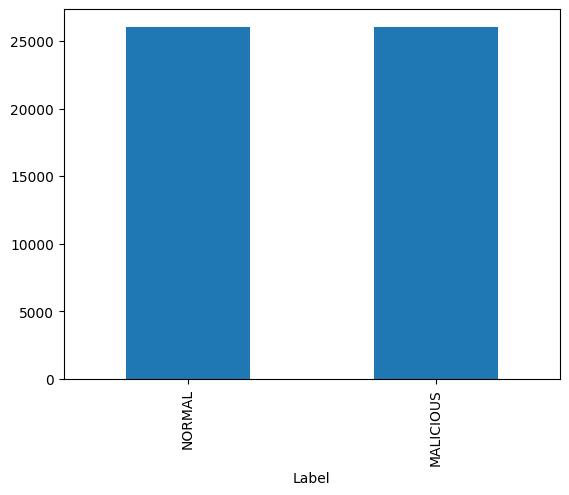

In [43]:
det_df.Label.value_counts().plot(kind="bar")

In [44]:
import time
from loguru import logger
import numpy as np
import pandas as pd
from sklearn.base import ClassifierMixin
from sklearn.base import clone
from sklearn.metrics import f1_score
from sklearn.inspection import permutation_importance


class RFE:

    def __init__(
        self,
        model: ClassifierMixin,
        train_features: pd.DataFrame,
        train_labels: pd.Series,
        test_features: pd.DataFrame,
        test_labels: pd.Series,
    ):
        """
        Initialize the Recursive Feature Elimination (RFE) class with the given model and dataset.
            A scikit-learn compatible classifier model to be used for feature elimination.
            The training dataset features.
            The training dataset labels.
        test_features : pd.DataFrame
            The testing dataset features.
        test_labels : pd.Series
            The testing dataset labels.
        Attributes
            The classifier model provided for feature elimination.
        train_features : np.ndarray
            Scaled training dataset features.
            The training dataset labels.
        test_features : np.ndarray
            Scaled testing dataset features.
        test_labels : pd.Series
            The testing dataset labels.
        result : list
            A list to store the results of the feature elimination process.
        curr_step : int
            Tracks the current step in the feature elimination process.
        feature_mask : np.ndarray or None
            A mask indicating the selected features after elimination.
        orig_feature_names : list
            The original feature names from the training dataset.
        scaler : MinMaxScaler
            A MinMaxScaler instance used to scale the features.
        """
        self.model = model
        self.train_features = train_features
        self.train_labels = train_labels
        self.test_features = test_features
        self.test_labels = test_labels
        self.curr_step = 0
        self.feature_mask = None

        self.orig_feature_names = train_features.columns.tolist()

        # self.scaler = MinMaxScaler()
        # self.scaler.fit(self.train_features)
        # self.train_features = self.scaler.transform(self.train_features)
        # self.test_features = self.scaler.transform(self.test_features)
        self._result = []

    @property
    def result(self):
        """
        Returns the result of the feature elimination process.
        """
        cols = [
            "Step",
            "Removed Feature",
            "Max Feature",
            "Min Feature",
            "Max Importance",
            "Min Importance",
            "Score",
            "Num Features",
        ]
        if len(self._result) == 0:
            logger.warning("No results available. Please run the fit method first.")
            return pd.DataFrame(columns=cols)
        df = pd.DataFrame(self._result, columns=cols)
        return df

    def fit(self, feature_names: list | None = None):
        if feature_names is None:
            feature_names = self.orig_feature_names
        # init feat mask
        feature_mask = np.array([f in feature_names for f in self.orig_feature_names])

        if isinstance(self.train_features, pd.DataFrame):
            self.train_features = self.train_features.to_numpy()
        if isinstance(self.test_features, pd.DataFrame):
            self.test_features = self.test_features.to_numpy()

        x_train_sel = self.train_features[:, feature_mask]
        x_test_sel = self.test_features[:, feature_mask]
        current_indices = np.flatnonzero(feature_mask)
        current_feature_names = [self.orig_feature_names[i] for i in current_indices]
        logger.info(f"Step: {self.curr_step}, Feature Shape: {x_train_sel.shape}")
        model = clone(self.model)
        t0 = time.perf_counter()
        model.fit(x_train_sel, self.train_labels)
        # test_results = permutation_importance(
        #     model,
        #     x_test_sel,
        #     self.test_labels,
        #     n_repeats=10,
        #     random_state=42,
        #     n_jobs=-1,
        #     scoring="f1",
        # )

        # Evaluate on F1 score
        score = f1_score(self.test_labels, model.predict(x_test_sel), average="binary")
        # score = model.score(x_test_sel, self.test_labels)
        logger.info(
            f"Training time: {time.perf_counter() - t0:.4f}s, Score: {score:.4f}"
        )
        try:
            importances = model.feature_importances_
        except AttributeError:
            importances = model.coef_.flatten()
        # importances = test_results.importances_mean
        max_i = importances.argmax()
        min_i = importances.argmin()

        if feature_mask.sum() == 1:
            logger.info("Only one feature left, stopping")
            return self.result, self.current_feature_names
        # Eliminate least important feature
        remove_global_idx = current_indices[min_i]
        removed_feature_name = self.orig_feature_names[remove_global_idx]
        feature_mask[remove_global_idx] = False
        logger.info(
            f"Sum Imp. {sum(importances)} Max importance ({max_i}): {importances[max_i]:.4f} ({current_feature_names[max_i]}), Min importance ({min_i}): {importances[min_i]:.4f} ({current_feature_names[min_i]}), Removed feature: {removed_feature_name}"
        )
        self._result.append(
            [
                self.curr_step,
                removed_feature_name,
                current_feature_names[max_i],
                current_feature_names[min_i],
                importances[max_i],
                importances[min_i],
                score,
                x_test_sel.shape[1],
            ]
        )
        self.curr_step += 1
        self.current_feature_names = [
            self.orig_feature_names[i] for i in np.flatnonzero(feature_mask)
        ]
        self.feature_mask = feature_mask
        return self.result, self.current_feature_names

    def project(self, data: pd.DataFrame):

        data = data[:, self.feature_mask]

        return data

    def plot_results(self, fig_size: tuple = (10, 6)):
        """
        Plot the results of the RFE process.
        Parameters
        ----------
        fig_size : tuple
            The size of the figure to be plotted.
        """
        import matplotlib.pyplot as plt
        import seaborn as sns

        df = self.result
        # Sort normally
        df = df.sort_values(
            "Num Features", ascending=True
        )  # ascending=True so larger numbers are on the left
        max_score = df["Score"].max()
        max_score_idx = df["Score"].idxmax()

        # Plot with numeric x-axis
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df, x="Num Features", y="Score")
        # Highlight the maximum score point
        plt.scatter(
            df.loc[max_score_idx, "Num Features"],
            max_score,
            color="red",
            label=f"Max Score: {max_score:.4f}",
        )
        # annotate the max score point little below
        ann_txt = (df.loc[max_score_idx, "Num Features"] - 1, max_score - 0.001)
        plt.annotate(
            f"F1: {max_score:.4f}\nFeatures: {df.loc[max_score_idx, 'Num Features']}",
            xy=(df.loc[max_score_idx, "Num Features"], max_score),
            xytext=(df.loc[max_score_idx, "Num Features"] - 1.5, max_score - 0.002),
            arrowprops=dict(arrowstyle="->", color="gray"),
            fontsize=10,
            bbox=dict(
                boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", alpha=0.8
            ),
        )

        # Reverse the x-axis
        plt.gca().invert_xaxis()

        plt.title(
            f"F1 Score vs Number of Features for ({self.model.__class__.__name__})"
        )
        plt.xlabel("Number of Features (Descending Order)")
        plt.ylabel("F1 Score")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

#### DecisionTree

2025-05-18 18:21:56.610 | INFO     | __main__:fit:102 - Step: 0, Feature Shape: (39060, 96)
2025-05-18 18:21:57.453 | INFO     | __main__:fit:119 - Training time: 0.8420s, Score: 0.9975
2025-05-18 18:21:57.454 | INFO     | __main__:fit:137 - Sum Imp. 0.9999999999999998 Max importance (50): 0.6247 (bwdIAT_MEAN), Min importance (2): 0.0000 (protocol), Removed feature: protocol
2025-05-18 18:21:57.468 | INFO     | __main__:fit:102 - Step: 1, Feature Shape: (39060, 95)
2025-05-18 18:21:58.308 | INFO     | __main__:fit:119 - Training time: 0.8384s, Score: 0.9972
2025-05-18 18:21:58.309 | INFO     | __main__:fit:137 - Sum Imp. 1.0000000000000002 Max importance (49): 0.6248 (bwdIAT_MEAN), Min importance (0): 0.0000 (source port), Removed feature: source port
2025-05-18 18:21:58.322 | INFO     | __main__:fit:102 - Step: 2, Feature Shape: (39060, 94)
2025-05-18 18:21:59.110 | INFO     | __main__:fit:119 - Training time: 0.7866s, Score: 0.9977
2025-05-18 18:21:59.111 | INFO     | __main__:fit:13

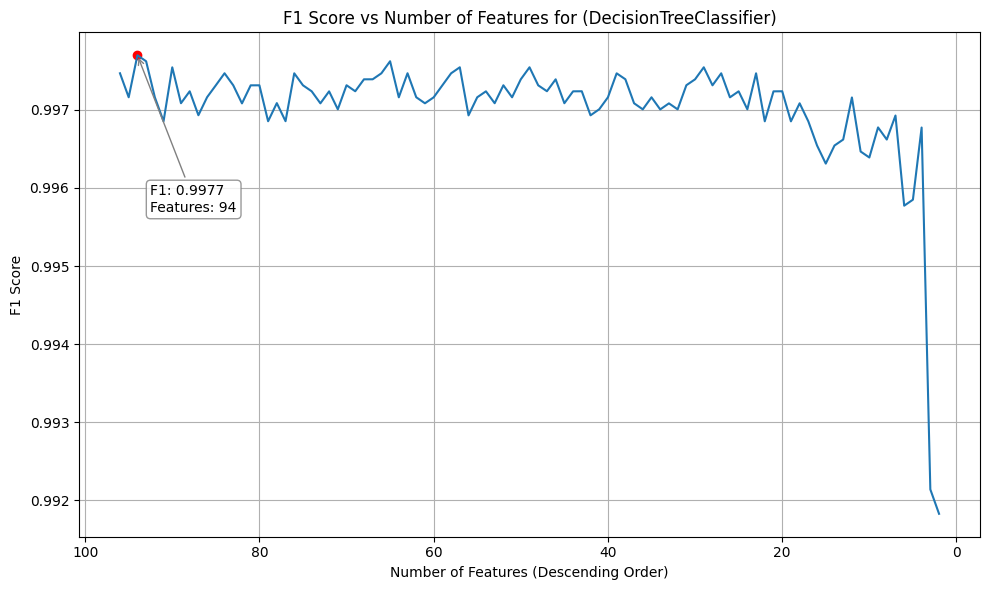

2025-05-18 18:22:41.384 | INFO     | __main__:<module>:47 - Top 10 features: ['bwdIAT_MEAN', 'TRbwdPktLenMIN', 'duration', 'FlowIAT_MIN', 'TotLenbwdDL', 'APPbwdPktLenMEAN', 'fwdIAT_MIN', 'IdleMIN', 'FlowIAT_MAX', 'APPfwdPktLenMEAN', 'bwdIAT_MIN']


In [68]:
from sklearn.model_selection import train_test_split
import os
import sys
from sklearn.tree import DecisionTreeClassifier
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# sys.path.append(os.path.abspath(r"E:\MSc Works\IDS"))
# from ids_expt.data.rfe import RFE


# shuffle the data
ddf = det_df.copy().sample(frac=1.0, random_state=42, replace=False)

# Binary encode labels (MALICIOUS = 1, others = 0)
ddf["Label"] = ddf["Label"].apply(lambda x: 1 if x == "MALICIOUS" else 0)

# Stratified split
train_df, test_df = train_test_split(
    ddf, test_size=0.25, random_state=42, stratify=ddf["Label"]
)

X_train = train_df.drop(columns=["Label"])
y_train = train_df["Label"]
X_test = test_df.drop(columns=["Label"])
y_test = test_df["Label"]


# Initialize RFE
rfe = RFE(
    model=DecisionTreeClassifier(),  # Increase from default 100
    train_features=X_train,
    train_labels=y_train,
    test_features=X_test,
    test_labels=y_test,
)

final_features = 1  # Target number of features
curr_features = X_train.columns.tolist()

for i in range(X_train.shape[1]):
    res, curr_features = rfe.fit(feature_names=curr_features)
    if len(curr_features) <= final_features:
        break
rfe.plot_results()
logger.info(
    f'Top 10 features: {curr_features + rfe.result["Removed Feature"].tolist()[::-1][:10]}'
)

#### RandomForest

2025-05-18 18:22:41.552 | INFO     | __main__:fit:102 - Step: 0, Feature Shape: (39060, 96)
2025-05-18 18:22:46.510 | INFO     | __main__:fit:119 - Training time: 4.9571s, Score: 0.9982
2025-05-18 18:22:46.523 | INFO     | __main__:fit:137 - Sum Imp. 0.9999999999999998 Max importance (50): 0.0580 (bwdIAT_MEAN), Min importance (2): 0.0000 (protocol), Removed feature: protocol
2025-05-18 18:22:46.538 | INFO     | __main__:fit:102 - Step: 1, Feature Shape: (39060, 95)
2025-05-18 18:22:51.554 | INFO     | __main__:fit:119 - Training time: 5.0142s, Score: 0.9979
2025-05-18 18:22:51.565 | INFO     | __main__:fit:137 - Sum Imp. 1.0000000000000002 Max importance (40): 0.0642 (FlowIAT_STD), Min importance (90): 0.0000 (corruptConfigFragments), Removed feature: corruptConfigFragments
2025-05-18 18:22:51.579 | INFO     | __main__:fit:102 - Step: 2, Feature Shape: (39060, 94)
2025-05-18 18:22:56.503 | INFO     | __main__:fit:119 - Training time: 4.9226s, Score: 0.9980
2025-05-18 18:22:56.515 | INF

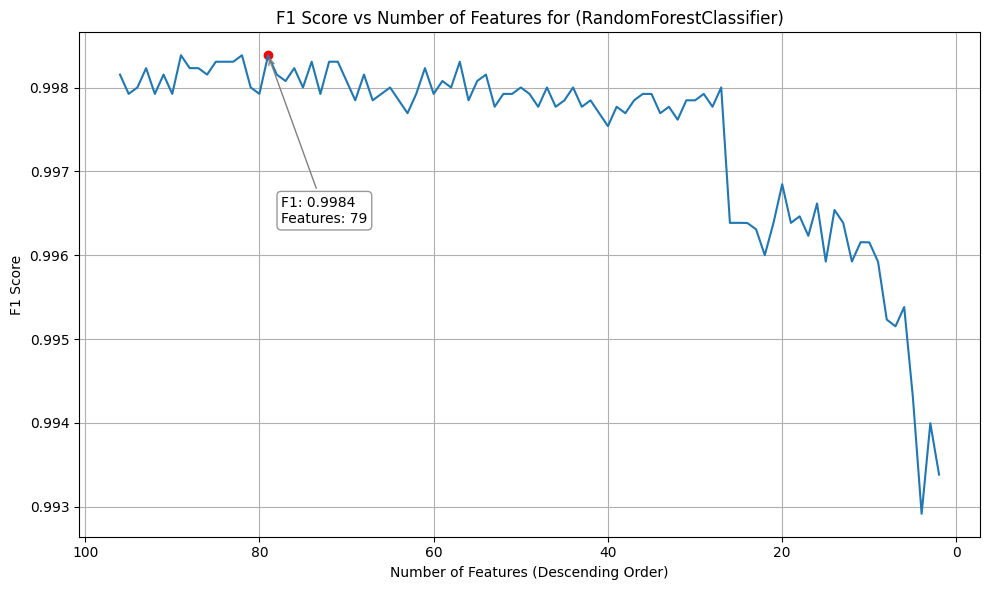

2025-05-18 18:30:16.191 | INFO     | __main__:<module>:42 - Top 10 features: ['DLflowBytes/sec', 'bwdIAT_MEAN', 'FlowIAT_STD', 'TRflowBytes/sec', 'pktsFromMASTER', 'TRfwdPktLenSTD', 'APPflowBytes/sec', 'FlowIAT_MAX', 'TRfwdHdrLen', 'APPfwdHdrLen', 'bwdIAT_MIN']


In [69]:
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")


# shuffle the data
ddf = det_df.copy().sample(frac=1.0, random_state=42, replace=False)
# ddf = ddf[[c for c in ddf.columns if c not in ["frameSrc", "frameDst"]]]

# Binary encode labels (MALICIOUS = 1, others = 0)
ddf["Label"] = ddf["Label"].apply(lambda x: 1 if x == "MALICIOUS" else 0)

# Stratified split
train_df, test_df = train_test_split(
    ddf, test_size=0.25, random_state=42, stratify=ddf["Label"]
)

X_train = train_df.drop(columns=["Label"])
y_train = train_df["Label"]
X_test = test_df.drop(columns=["Label"])
y_test = test_df["Label"]


# Initialize RFE
rfe = RFE(
    model=RandomForestClassifier(),
    train_features=X_train,
    train_labels=y_train,
    test_features=X_test,
    test_labels=y_test,
)

final_features = 1  # Target number of features
curr_features = X_train.columns.tolist()

for i in range(X_train.shape[1]):
    res, curr_features = rfe.fit(feature_names=curr_features)
    if len(curr_features) <= final_features:
        break
rfe.plot_results()
logger.info(
    f'Top 10 features: {curr_features + rfe.result["Removed Feature"].tolist()[::-1][:10]}'
)

In [121]:
# what happens to the accuracy and f1 if we remove the top 10 features
# shuffle the data
ddf = det_df.copy().sample(frac=1.0, random_state=42, replace=False)
# top_features = curr_features + rfe.result["Max Feature"].tolist()[::-1][:10]
# top_features = top_features + ddf.columns.tolist()[:95]
ddf["Label"] = ddf["Label"].apply(lambda x: 1 if x == "MALICIOUS" else 0)

# ddf = ddf[["protocol", "Label"]]
# # remove the top 10 features
# for feature in top_features:
#     if feature in ddf.columns:
#         del ddf[feature]


# Stratified split
train_df, test_df = train_test_split(
    ddf, test_size=0.25, random_state=42, stratify=ddf["Label"]
)

X_train = train_df.drop(columns=["Label"])
y_train = train_df["Label"]
X_test = test_df.drop(columns=["Label"])
y_test = test_df["Label"]

# scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred, average="binary")
acc = rf.score(X_test, y_test)
logger.info(f"Shape: {X_train.shape}, Accuracy: {acc:.4f}, F1: {f1:.4f}")

2025-05-18 20:17:23.411 | INFO     | __main__:<module>:37 - Shape: (39060, 1), Accuracy: 0.5000, F1: 0.6667


In [111]:
train_df.pktsFromSLAVE.describe()

count    39060.000000
mean         0.639291
std          0.399708
min          0.000000
25%          0.202899
50%          0.927536
75%          0.971014
max          1.000000
Name: pktsFromSLAVE, dtype: float64

#### LogisticRegression

2025-05-18 18:30:16.232 | INFO     | __main__:fit:102 - Step: 0, Feature Shape: (39060, 96)
2025-05-18 18:30:17.557 | INFO     | __main__:fit:119 - Training time: 1.3235s, Score: 0.9284
2025-05-18 18:30:17.558 | INFO     | __main__:fit:137 - Sum Imp. 2.3826020310274355e-05 Max importance (46): 0.0000 (fwdIAT_STD), Min importance (42): -0.0000 (FlowIAT_MAX), Removed feature: FlowIAT_MAX
2025-05-18 18:30:17.573 | INFO     | __main__:fit:102 - Step: 1, Feature Shape: (39060, 95)
2025-05-18 18:30:18.414 | INFO     | __main__:fit:119 - Training time: 0.8408s, Score: 0.9370
2025-05-18 18:30:18.416 | INFO     | __main__:fit:137 - Sum Imp. 1.3665381130519538e-05 Max importance (45): 0.0000 (fwdIAT_STD), Min importance (41): -0.0000 (FlowIAT_STD), Removed feature: FlowIAT_STD
2025-05-18 18:30:18.431 | INFO     | __main__:fit:102 - Step: 2, Feature Shape: (39060, 94)
2025-05-18 18:30:19.365 | INFO     | __main__:fit:119 - Training time: 0.9329s, Score: 0.9436
2025-05-18 18:30:19.366 | INFO     |

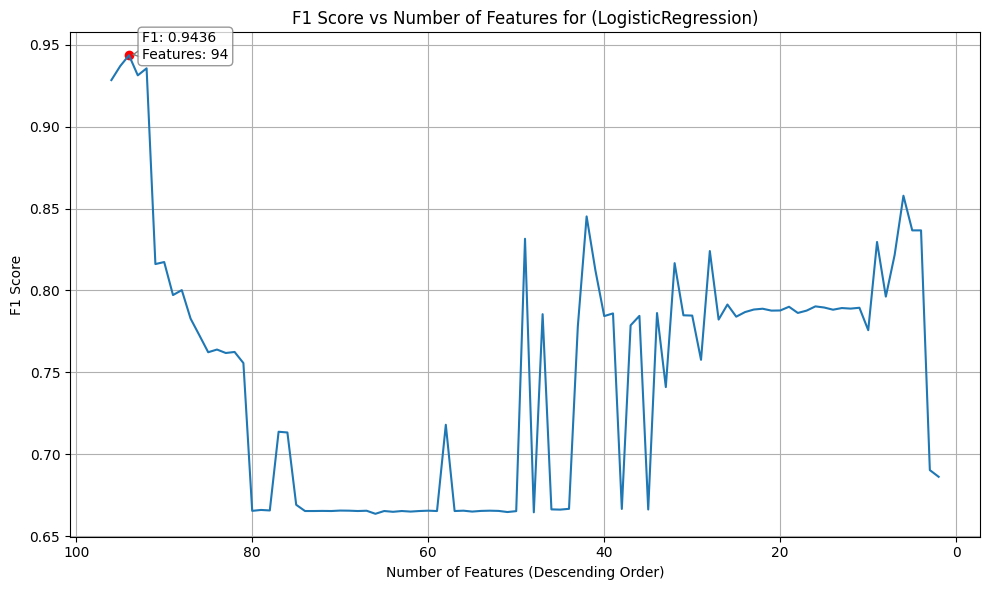

2025-05-18 18:31:12.412 | INFO     | __main__:<module>:23 - Top 10 features: ['APPbwdPktLenMAX', 'APPbwdHdrLen', 'FlowIAT_MIN', 'APPflowBytes/sec', 'deviceRestartFragments', 'firstPacketDIR', 'corruptConfigFragments', 'deviceTroubleFragments', 'frameDst', 'TotLenbwdTR', 'APPbwdPktLenSTD']


In [70]:
from sklearn.linear_model import LogisticRegression
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Initialize RFE
rfe = RFE(
    model=LogisticRegression(max_iter=100),
    train_features=X_train,
    train_labels=y_train,
    test_features=X_test,
    test_labels=y_test,
)

final_features = 1  # Target number of features
curr_features = X_train.columns.tolist()

for i in range(X_train.shape[1]):
    res, curr_features = rfe.fit(feature_names=curr_features)
    if len(curr_features) <= final_features:
        break
rfe.plot_results()
logger.info(
    f'Top 10 features: {curr_features + rfe.result["Removed Feature"].tolist()[::-1][:10]}'
)

#### XGB

2025-05-18 18:31:13.418 | INFO     | __main__:fit:102 - Step: 0, Feature Shape: (39060, 96)
2025-05-18 18:31:14.344 | INFO     | __main__:fit:119 - Training time: 0.9241s, Score: 0.9988
2025-05-18 18:31:14.361 | INFO     | __main__:fit:137 - Sum Imp. 1.0000000845921022 Max importance (50): 0.5226 (bwdIAT_MEAN), Min importance (2): 0.0000 (protocol), Removed feature: protocol
2025-05-18 18:31:14.378 | INFO     | __main__:fit:102 - Step: 1, Feature Shape: (39060, 95)
2025-05-18 18:31:15.027 | INFO     | __main__:fit:119 - Training time: 0.6474s, Score: 0.9988
2025-05-18 18:31:15.029 | INFO     | __main__:fit:137 - Sum Imp. 0.9999999815263436 Max importance (49): 0.5226 (bwdIAT_MEAN), Min importance (7): 0.0000 (TotLenfwdAPP), Removed feature: TotLenfwdAPP
2025-05-18 18:31:15.046 | INFO     | __main__:fit:102 - Step: 2, Feature Shape: (39060, 94)
2025-05-18 18:31:15.673 | INFO     | __main__:fit:119 - Training time: 0.6259s, Score: 0.9988
2025-05-18 18:31:15.675 | INFO     | __main__:fit:

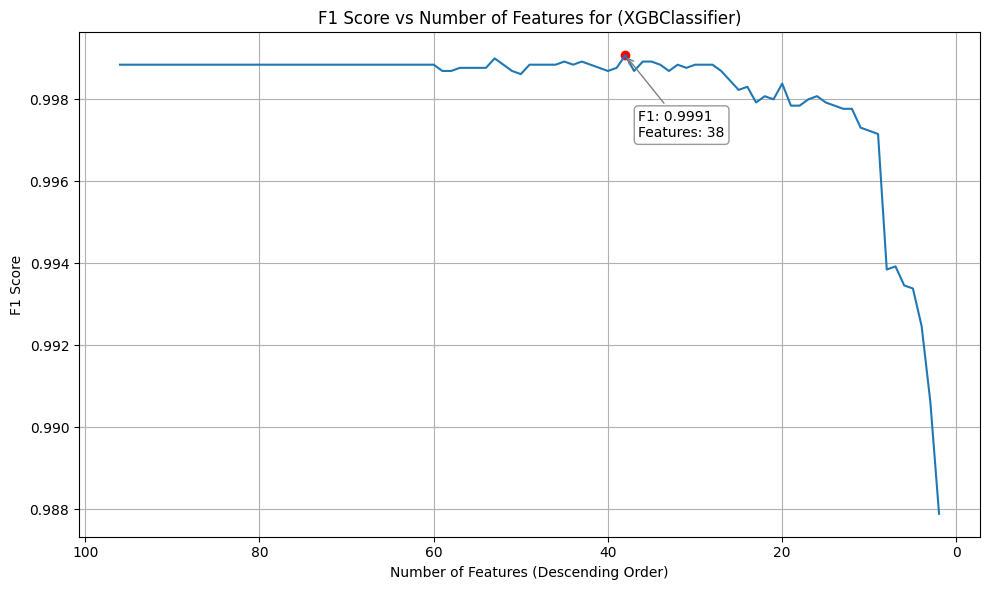

2025-05-18 18:31:53.084 | INFO     | __main__:<module>:21 - Top 10 features: ['DLbwdPktLenMIN', 'bwdIAT_MEAN', 'TotalBwdIAT', 'FlowIAT_MAX', 'pktsFromMASTER', 'DLfwdPktLenMIN', 'TotLenbwdDL', 'TotalFwdIAT', 'FlowIAT_MIN', 'TotalBwdPkts', 'fwdIAT_MAX']


In [71]:
# XGB
from xgboost import XGBClassifier


rfe = RFE(
    model=XGBClassifier(),
    train_features=X_train,
    train_labels=y_train,
    test_features=X_test,
    test_labels=y_test,
)

final_features = 1  # Target number of features
curr_features = X_train.columns.tolist()

for i in range(X_train.shape[1]):
    res, curr_features = rfe.fit(feature_names=curr_features)
    if len(curr_features) <= final_features:
        break
rfe.plot_results()
logger.info(
    f'Top 10 features: {curr_features + rfe.result["Removed Feature"].tolist()[::-1][:10]}'
)

In [72]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# scaler
from sklearn.preprocessing import MinMaxScaler

# need RF, LR, DT, GNB and XGB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


class SKClassifiers:
    def __init__(
        self,
        models: list[BaseEstimator],
        train_features: pd.DataFrame,
        train_labels: pd.Series,
        test_features: pd.DataFrame,
        test_labels: pd.Series,
    ):

        self.models = models
        self.train_features = train_features
        self.train_labels = train_labels
        self.test_features = test_features
        self.test_labels = test_labels
        self.results = {}
        self.scaler = MinMaxScaler()
        self.scaler.fit(self.train_features)
        self.train_features = self.scaler.transform(self.train_features)
        self.test_features = self.scaler.transform(self.test_features)

    def fit(self):
        for model in self.models:
            model_name = type(model).__name__
            logger.info(f"Training {model_name}")
            model.fit(self.train_features, self.train_labels)
            y_pred = model.predict(self.test_features)
            accuracy = accuracy_score(self.test_labels, y_pred)
            report = classification_report(self.test_labels, y_pred, output_dict=True)
            self.results[model_name] = {
                "accuracy": accuracy,
                "report": report,
                "confusion_matrix": confusion_matrix(self.test_labels, y_pred),
                "f1_score": report["weighted avg"]["f1-score"],
                "precision": report["weighted avg"]["precision"],
                "recall": report["weighted avg"]["recall"],
            }
            logger.info(f"{model_name} Accuracy: {accuracy}")
        return self.results


clfs = [
    RandomForestClassifier(max_depth=15, n_estimators=100),
    DecisionTreeClassifier(max_depth=15),
    LogisticRegression(max_iter=1000),
    GaussianNB(),
    XGBClassifier(max_depth=15, n_estimators=100),
]
clf = SKClassifiers(
    models=clfs,
    train_features=X_train,
    train_labels=y_train,
    test_features=X_test,
    test_labels=y_test,
)
results = clf.fit()
logger.info("Results:")
for model_name, result in results.items():
    logger.info(f"{model_name} Accuracy: {result['accuracy']}")
    logger.info(f"F1 Score: {result['f1_score']}")
    logger.info(f"Precision: {result['precision']}")
    logger.info(f"Recall: {result['recall']}")
    logger.info(f"Confusion Matrix:\n{result['confusion_matrix']}")

2025-05-18 18:31:53.188 | INFO     | __main__:fit:39 - Training RandomForestClassifier
2025-05-18 18:31:58.233 | INFO     | __main__:fit:52 - RandomForestClassifier Accuracy: 0.9982334869431644
2025-05-18 18:31:58.234 | INFO     | __main__:fit:39 - Training DecisionTreeClassifier
2025-05-18 18:31:59.017 | INFO     | __main__:fit:52 - DecisionTreeClassifier Accuracy: 0.9971582181259601
2025-05-18 18:31:59.018 | INFO     | __main__:fit:39 - Training LogisticRegression
2025-05-18 18:31:59.741 | INFO     | __main__:fit:52 - LogisticRegression Accuracy: 0.9802611367127496
2025-05-18 18:31:59.742 | INFO     | __main__:fit:39 - Training GaussianNB
2025-05-18 18:31:59.849 | INFO     | __main__:fit:52 - GaussianNB Accuracy: 0.629416282642089
2025-05-18 18:31:59.850 | INFO     | __main__:fit:39 - Training XGBClassifier
2025-05-18 18:32:00.618 | INFO     | __main__:fit:52 - XGBClassifier Accuracy: 0.998694316436252
2025-05-18 18:32:00.620 | INFO     | __main__:<module>:71 - Results:
2025-05-18 18

## Attacking and Defending DNP3 ICS/SCADA Systems

In [22]:
import pandas as pd
from pathlib import Path
from loguru import logger


def load_csv_files(all_files: list[Path]) -> pd.DataFrame:
    """
    Load all CSV files into a single DataFrame.
    """
    if len(all_files) == 0:
        logger.warning("No CSV files found.")
        return pd.DataFrame()

    dataframes = []
    for file in all_files:
        logger.info(f"Loading {file}")
        df = pd.read_csv(file, low_memory=False)
        if "Label" in df.columns:
            if "No Label" in df["Label"].unique():
                del df["Label"]

        df.columns = [c.strip() for c in df.columns]
        dataframes.append(df)
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df


data_root = Path(r"E:\MSc Works\IDS\data\Custom_DNP3_Parser")
logger.info(f"Data root: {data_root}")
all_files = list(data_root.glob("*.csv"))
logger.info(f"Found {len(all_files)} files in {data_root}")
combined_df = load_csv_files(all_files)
logger.info(f"Combined DataFrame shape: {combined_df.shape}")

2025-05-18 15:41:20.445 | INFO     | __main__:<module>:29 - Data root: E:\MSc Works\IDS\data\Custom_DNP3_Parser
2025-05-18 15:41:20.456 | INFO     | __main__:<module>:31 - Found 71 files in E:\MSc Works\IDS\data\Custom_DNP3_Parser
2025-05-18 15:41:20.457 | INFO     | __main__:load_csv_files:16 - Loading E:\MSc Works\IDS\data\Custom_DNP3_Parser\20200508_DNP3_Disable_Unsolicited_Messages_Attack_UOWM_DNP3_Dataset_Slave_05.pcapDNP3_FLOWLABELED.csv
2025-05-18 15:41:20.474 | INFO     | __main__:load_csv_files:16 - Loading E:\MSc Works\IDS\data\Custom_DNP3_Parser\20200514_Disable_Unsolicited_Messages_Attack_UOWM_DNP3_Dataset_Attacker_01.pcapDNP3_FLOWLABELED.csv
2025-05-18 15:41:20.500 | INFO     | __main__:load_csv_files:16 - Loading E:\MSc Works\IDS\data\Custom_DNP3_Parser\20200514_Disable_Unsolicited_Messages_Attack_UOWM_DNP3_Dataset_Attacker_02.pcapDNP3_FLOWLABELED.csv
2025-05-18 15:41:20.543 | INFO     | __main__:load_csv_files:16 - Loading E:\MSc Works\IDS\data\Custom_DNP3_Parser\2020051

In [24]:
ignore_columns = [
    "File",
    "flow ID",
    "binary_label",
    "Timestamp",
    "source IP",
    "destination IP",
    "date",
    "Unnamed: 0",
    "Unnamed: 0.1",
    "firstPacketDIR",
]
combined_df = combined_df[[c for c in combined_df.columns if c not in ignore_columns]]
# combined_df.firstPacketDIR = combined_df["firstPacketDIR"].apply(
#     lambda x: 1 if x == "MASTER" else 0
# )

In [23]:
def oversample_class(df: pd.DataFrame, label: str) -> pd.DataFrame:
    """
    Oversample the specified class in the DataFrame.
    """
    logger.info(f"Before oversampling: {df[label].value_counts()}")
    label_counts = df[label].value_counts()
    max_count = label_counts.max()
    for lbl in label_counts.index:
        count = label_counts[lbl]
        if count < max_count:
            needed = max_count - count
            logger.info(f"Label {lbl} needs {needed} samples")
            oversample_df = df[df[label] == lbl].sample(needed, replace=True)
            df = pd.concat([df, oversample_df], ignore_index=True)

    # Shuffle the DataFrame
    df = df.sample(frac=1, random_state=42, replace=False).reset_index(drop=True)
    logger.info(f"After oversampling: {df[label].value_counts()}")
    return df


def undersample_class(df: pd.DataFrame, label: str) -> pd.DataFrame:
    """
    Undersample the specified class in the DataFrame.
    """
    logger.info(f"Before undersampling: {df[label].value_counts()}")
    label_counts = df[label].value_counts()
    min_count = label_counts.min()
    for lbl in label_counts.index:
        count = label_counts[lbl]
        if count > min_count:
            needed = count - min_count
            logger.info(f"Label {lbl} needs to be reduced by {needed} samples")
            undersample_df = df[df[label] == lbl].sample(needed, replace=False)
            df = df.drop(undersample_df.index)

    # Shuffle the DataFrame
    df = df.sample(frac=1, random_state=42, replace=False).reset_index(drop=True)
    logger.info(f"After undersampling: {df[label].value_counts()}")
    return df

### Modelling

In [25]:
# DT, DNN, KNN, NB, RF
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

# scaler
from sklearn.preprocessing import MinMaxScaler

RF = RandomForestClassifier(random_state=42)
DT = DecisionTreeClassifier(random_state=42)
KNN = KNeighborsClassifier()
NB = GaussianNB()
models = [RF, DT, KNN, NB]

# shuffle the data
ddf = combined_df.copy().sample(frac=1.0, random_state=42, replace=False)

X = ddf.drop("Label", axis=1).values
y = ddf["Label"]

# Normalization to [0,1] range
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# sclaer
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# fit
for model in models:
    model_name = type(model).__name__
    logger.info(f"Training {model_name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    logger.info(f"{model_name} Accuracy: {accuracy}")
    logger.info(f"{model_name} F1 Score: {f1}")

2025-05-18 15:41:25.310 | INFO     | __main__:<module>:43 - Training RandomForestClassifier


2025-05-18 15:41:38.869 | INFO     | __main__:<module>:48 - RandomForestClassifier Accuracy: 0.964745175655616
2025-05-18 15:41:38.869 | INFO     | __main__:<module>:49 - RandomForestClassifier F1 Score: 0.9648139539363886
2025-05-18 15:41:38.870 | INFO     | __main__:<module>:43 - Training DecisionTreeClassifier
2025-05-18 15:41:40.397 | INFO     | __main__:<module>:48 - DecisionTreeClassifier Accuracy: 0.9745175655616032
2025-05-18 15:41:40.398 | INFO     | __main__:<module>:49 - DecisionTreeClassifier F1 Score: 0.9745238553739216
2025-05-18 15:41:40.399 | INFO     | __main__:<module>:43 - Training KNeighborsClassifier
2025-05-18 15:41:42.061 | INFO     | __main__:<module>:48 - KNeighborsClassifier Accuracy: 0.9716724393864423
2025-05-18 15:41:42.062 | INFO     | __main__:<module>:49 - KNeighborsClassifier F1 Score: 0.971965316743756
2025-05-18 15:41:42.065 | INFO     | __main__:<module>:43 - Training GaussianNB
2025-05-18 15:41:42.389 | INFO     | __main__:<module>:48 - GaussianNB A

### Keras

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load dataset (replace with your DNP3 flow data)
df = combined_df.copy()

# Preprocessing
X = df.drop("Label", axis=1).values
y = pd.get_dummies(df["Label"]).values  # One-hot encoding

# Normalization to [0,1] range
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42
)

# DNN Architecture
dnn_model = Sequential(
    [
        Dense(90, activation="relu", input_shape=(X_train.shape[1],)),
        Dense(90, activation="relu"),
        Dense(90, activation="relu"),
        Dense(90, activation="relu"),
        Dense(90, activation="relu"),
        Dense(90, activation="relu"),
        Dense(90, activation="relu"),
        Dense(90, activation="relu"),
        Dense(90, activation="relu"),
        Dense(y_train.shape[1], activation="softmax"),
    ]
)

# Compile model
optimizer = Adam(learning_rate=0.0001)
dnn_model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

# Training
history = dnn_model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=32,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True),
        ModelCheckpoint(
            "dnp3_best_model.h5", monitor="val_loss", save_best_only=True, verbose=1
        ),
    ],
)

# Evaluation
loss, accuracy = dnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/1000


e:\MSc Works\IDS\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


940/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5455 - loss: 1.2648
Epoch 1: val_loss improved from inf to 0.43606, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5467 - loss: 1.2604 - val_accuracy: 0.7598 - val_loss: 0.4361
Epoch 2/1000
940/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7587 - loss: 0.4327
Epoch 2: val_loss did not improve from 0.43606
948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7587 - loss: 0.4326 - val_accuracy: 0.7447 - val_loss: 0.4639
Epoch 3/1000
935/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7640 - loss: 0.4217
Epoch 3: val_loss improved from 0.43606 to 0.39245, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7641 - loss: 0.4215 - val_accuracy: 0.7965 - val_loss: 0.3925
Epoch 4/1000
944/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7802 - loss: 0.3908
Epoch 4: val_loss improved from 0.39245 to 0.36188, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7802 - loss: 0.3908 - val_accuracy: 0.7950 - val_loss: 0.3619
Epoch 5/1000
943/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7868 - loss: 0.3713
Epoch 5: val_loss improved from 0.36188 to 0.35341, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7868 - loss: 0.3713 - val_accuracy: 0.8045 - val_loss: 0.3534
Epoch 6/1000
947/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7945 - loss: 0.3590
Epoch 6: val_loss improved from 0.35341 to 0.34664, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7945 - loss: 0.3591 - val_accuracy: 0.8112 - val_loss: 0.3466
Epoch 7/1000
945/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7942 - loss: 0.3604
Epoch 7: val_loss improved from 0.34664 to 0.34457, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7942 - loss: 0.3604 - val_accuracy: 0.8011 - val_loss: 0.3446
Epoch 8/1000
944/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7978 - loss: 0.3545
Epoch 8: val_loss improved from 0.34457 to 0.34280, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7978 - loss: 0.3545 - val_accuracy: 0.8058 - val_loss: 0.3428
Epoch 9/1000
945/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8040 - loss: 0.3441
Epoch 9: val_loss improved from 0.34280 to 0.33183, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8040 - loss: 0.3441 - val_accuracy: 0.8128 - val_loss: 0.3318
Epoch 10/1000
935/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8039 - loss: 0.3480
Epoch 10: val_loss improved from 0.33183 to 0.32820, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8039 - loss: 0.3480 - val_accuracy: 0.8191 - val_loss: 0.3282
Epoch 11/1000
944/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8085 - loss: 0.3392
Epoch 11: val_loss did not improve from 0.32820
948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8085 - loss: 0.3392 - val_accuracy: 0.8138 - val_loss: 0.3436
Epoch 12/1000
945/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8133 - loss: 0.3370
Epoch 12: val_loss improved from 0.32820 to 0.31806, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8133 - loss: 0.3370 - val_accuracy: 0.8195 - val_loss: 0.3181
Epoch 13/1000
940/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8084 - loss: 0.3475
Epoch 13: val_loss improved from 0.31806 to 0.31334, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8084 - loss: 0.3474 - val_accuracy: 0.8392 - val_loss: 0.3133
Epoch 14/1000
939/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8185 - loss: 0.3282
Epoch 14: val_loss did not improve from 0.31334
948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8185 - loss: 0.3282 - val_accuracy: 0.8417 - val_loss: 0.3213
Epoch 15/1000
945/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8260 - loss: 0.3272
Epoch 15: val_loss improved from 0.31334 to 0.30533, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8260 - loss: 0.3272 - val_accuracy: 0.8333 - val_loss: 0.3053
Epoch 16/1000
936/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8368 - loss: 0.3100
Epoch 16: val_loss improved from 0.30533 to 0.28884, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8367 - loss: 0.3100 - val_accuracy: 0.8450 - val_loss: 0.2888
Epoch 17/1000
941/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8326 - loss: 0.3078
Epoch 17: val_loss improved from 0.28884 to 0.28597, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8326 - loss: 0.3078 - val_accuracy: 0.8469 - val_loss: 0.2860
Epoch 18/1000
948/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8352 - loss: 0.3104
Epoch 18: val_loss did not improve from 0.28597
948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8352 - loss: 0.3104 - val_accuracy: 0.8549 - val_loss: 0.2946
Epoch 19/1000
934/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8408 - loss: 0.3016
Epoch 19: val_loss did not improve from 0.28597
948/948 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8407 - loss: 0.3016 - val_accuracy: 0.8321 - val_loss: 0.3341
Epoch 20/1000
940/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8405 - loss: 0.2989
Epoch 20: val_loss did not improve from 0.28597
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8405 - loss: 0.2989 - val_accuracy: 0.8226 - val_loss: 0.3149
Epoch 21/1000
935/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8393 - loss: 0.2927
Epoch 21: val_loss improved fro

948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8393 - loss: 0.2927 - val_accuracy: 0.8554 - val_loss: 0.2763
Epoch 22/1000
943/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8448 - loss: 0.2852
Epoch 22: val_loss did not improve from 0.27634
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8448 - loss: 0.2852 - val_accuracy: 0.8397 - val_loss: 0.2975
Epoch 23/1000
940/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8471 - loss: 0.2882
Epoch 23: val_loss improved from 0.27634 to 0.27288, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8471 - loss: 0.2882 - val_accuracy: 0.8700 - val_loss: 0.2729
Epoch 24/1000
938/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8482 - loss: 0.2807
Epoch 24: val_loss improved from 0.27288 to 0.26986, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8482 - loss: 0.2807 - val_accuracy: 0.8463 - val_loss: 0.2699
Epoch 25/1000
942/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8518 - loss: 0.2758
Epoch 25: val_loss improved from 0.26986 to 0.26312, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8518 - loss: 0.2758 - val_accuracy: 0.8606 - val_loss: 0.2631
Epoch 26/1000
936/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8539 - loss: 0.2754
Epoch 26: val_loss did not improve from 0.26312
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8540 - loss: 0.2754 - val_accuracy: 0.8664 - val_loss: 0.2686
Epoch 27/1000
941/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8578 - loss: 0.2680
Epoch 27: val_loss did not improve from 0.26312
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8578 - loss: 0.2680 - val_accuracy: 0.8613 - val_loss: 0.2845
Epoch 28/1000
941/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8561 - loss: 0.2703
Epoch 28: val_loss did not improve from 0.26312
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8562 - loss: 0.2703 - val_accuracy: 0.8680 - val_loss: 0.2644
Epoch 29/1000
945/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8622 - loss: 0.2607
Epoch 29: val_loss improved from

948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8622 - loss: 0.2607 - val_accuracy: 0.8793 - val_loss: 0.2477
Epoch 30/1000
935/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8620 - loss: 0.2626
Epoch 30: val_loss did not improve from 0.24766
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8620 - loss: 0.2625 - val_accuracy: 0.8672 - val_loss: 0.2603
Epoch 31/1000
942/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8686 - loss: 0.2547
Epoch 31: val_loss did not improve from 0.24766
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8687 - loss: 0.2547 - val_accuracy: 0.8634 - val_loss: 0.2700
Epoch 32/1000
939/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8732 - loss: 0.2496
Epoch 32: val_loss improved from 0.24766 to 0.21875, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8732 - loss: 0.2495 - val_accuracy: 0.8977 - val_loss: 0.2188
Epoch 33/1000
946/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8848 - loss: 0.2334
Epoch 33: val_loss did not improve from 0.21875
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8848 - loss: 0.2334 - val_accuracy: 0.8974 - val_loss: 0.2275
Epoch 34/1000
934/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8928 - loss: 0.2291
Epoch 34: val_loss did not improve from 0.21875
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8928 - loss: 0.2290 - val_accuracy: 0.8766 - val_loss: 0.2504
Epoch 35/1000
939/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8984 - loss: 0.2172
Epoch 35: val_loss improved from 0.21875 to 0.21510, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8985 - loss: 0.2172 - val_accuracy: 0.9087 - val_loss: 0.2151
Epoch 36/1000
934/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9048 - loss: 0.2090
Epoch 36: val_loss improved from 0.21510 to 0.20124, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9048 - loss: 0.2089 - val_accuracy: 0.9181 - val_loss: 0.2012
Epoch 37/1000
948/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9122 - loss: 0.1997
Epoch 37: val_loss did not improve from 0.20124
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9122 - loss: 0.1996 - val_accuracy: 0.9093 - val_loss: 0.2029
Epoch 38/1000
948/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9171 - loss: 0.1885
Epoch 38: val_loss did not improve from 0.20124
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9171 - loss: 0.1885 - val_accuracy: 0.9013 - val_loss: 0.2066
Epoch 39/1000
941/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9213 - loss: 0.1801
Epoch 39: val_loss did not improve from 0.20124
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9213 - loss: 0.1801 - val_accuracy: 0.9195 - val_loss: 0.2284
Epoch 40/1000
942/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9260 - loss: 0.1706
Epoch 40: val_loss improved from

948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9260 - loss: 0.1706 - val_accuracy: 0.9362 - val_loss: 0.1495
Epoch 41/1000
942/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9294 - loss: 0.1574
Epoch 41: val_loss did not improve from 0.14952
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9294 - loss: 0.1574 - val_accuracy: 0.9188 - val_loss: 0.1689
Epoch 42/1000
944/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9300 - loss: 0.1536
Epoch 42: val_loss did not improve from 0.14952
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9300 - loss: 0.1536 - val_accuracy: 0.9039 - val_loss: 0.2129
Epoch 43/1000
942/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9285 - loss: 0.1601
Epoch 43: val_loss improved from 0.14952 to 0.14497, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9285 - loss: 0.1600 - val_accuracy: 0.9384 - val_loss: 0.1450
Epoch 44/1000
936/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9304 - loss: 0.1509
Epoch 44: val_loss improved from 0.14497 to 0.13081, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9305 - loss: 0.1509 - val_accuracy: 0.9411 - val_loss: 0.1308
Epoch 45/1000
945/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9363 - loss: 0.1350
Epoch 45: val_loss did not improve from 0.13081
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9363 - loss: 0.1350 - val_accuracy: 0.9328 - val_loss: 0.1318
Epoch 46/1000
948/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9384 - loss: 0.1314
Epoch 46: val_loss did not improve from 0.13081
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9384 - loss: 0.1315 - val_accuracy: 0.9293 - val_loss: 0.1665
Epoch 47/1000
937/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9387 - loss: 0.1371
Epoch 47: val_loss improved from 0.13081 to 0.11022, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9388 - loss: 0.1370 - val_accuracy: 0.9520 - val_loss: 0.1102
Epoch 48/1000
948/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9450 - loss: 0.1214
Epoch 48: val_loss did not improve from 0.11022
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9450 - loss: 0.1214 - val_accuracy: 0.9358 - val_loss: 0.1490
Epoch 49/1000
941/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9418 - loss: 0.1286
Epoch 49: val_loss did not improve from 0.11022
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9418 - loss: 0.1286 - val_accuracy: 0.9131 - val_loss: 0.1952
Epoch 50/1000
944/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9424 - loss: 0.1234
Epoch 50: val_loss did not improve from 0.11022
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9424 - loss: 0.1234 - val_accuracy: 0.9341 - val_loss: 0.1499
Epoch 51/1000
934/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9454 - loss: 0.1213
Epoch 51: val_loss did not impro

948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9515 - loss: 0.1106 - val_accuracy: 0.9548 - val_loss: 0.1024
Epoch 55/1000
942/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9515 - loss: 0.1072
Epoch 55: val_loss did not improve from 0.10241
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9515 - loss: 0.1072 - val_accuracy: 0.9466 - val_loss: 0.1264
Epoch 56/1000
947/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9421 - loss: 0.1308
Epoch 56: val_loss did not improve from 0.10241
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9422 - loss: 0.1308 - val_accuracy: 0.9530 - val_loss: 0.1093
Epoch 57/1000
945/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9434 - loss: 0.1236
Epoch 57: val_loss did not improve from 0.10241
948/948 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9434 - loss: 0.1235 - val_accuracy: 0.9244 - val_loss: 0.1905
Epoch 58/1000
939/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9498 - loss: 0.1085
Epoch 58: val_loss did not impr

948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9489 - loss: 0.1137 - val_accuracy: 0.9492 - val_loss: 0.1006
Epoch 61/1000
934/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9511 - loss: 0.1074
Epoch 61: val_loss did not improve from 0.10062
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9511 - loss: 0.1074 - val_accuracy: 0.9618 - val_loss: 0.1012
Epoch 62/1000
946/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9488 - loss: 0.1149
Epoch 62: val_loss did not improve from 0.10062
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9488 - loss: 0.1148 - val_accuracy: 0.9535 - val_loss: 0.1020
Epoch 63/1000
938/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9514 - loss: 0.1055
Epoch 63: val_loss did not improve from 0.10062
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9513 - loss: 0.1057 - val_accuracy: 0.9506 - val_loss: 0.1109
Epoch 64/1000
943/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9502 - loss: 0.1054
Epoch 64: val_loss improved from

948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9502 - loss: 0.1054 - val_accuracy: 0.9561 - val_loss: 0.0964
Epoch 65/1000
944/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9482 - loss: 0.1175
Epoch 65: val_loss did not improve from 0.09643
948/948 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9482 - loss: 0.1175 - val_accuracy: 0.9605 - val_loss: 0.0981
Epoch 66/1000
943/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9534 - loss: 0.0979
Epoch 66: val_loss did not improve from 0.09643
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9534 - loss: 0.0979 - val_accuracy: 0.9449 - val_loss: 0.1225
Epoch 67/1000
947/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9549 - loss: 0.0989
Epoch 67: val_loss did not improve from 0.09643
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9549 - loss: 0.0989 - val_accuracy: 0.9494 - val_loss: 0.1030
Epoch 68/1000
942/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9504 - loss: 0.1103
Epoch 68: val_loss did not impro

948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9580 - loss: 0.0921 - val_accuracy: 0.9593 - val_loss: 0.0906
Epoch 81/1000
943/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9546 - loss: 0.0982
Epoch 81: val_loss did not improve from 0.09064
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9546 - loss: 0.0982 - val_accuracy: 0.9653 - val_loss: 0.0932
Epoch 82/1000
943/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9585 - loss: 0.0887
Epoch 82: val_loss did not improve from 0.09064
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9585 - loss: 0.0887 - val_accuracy: 0.9590 - val_loss: 0.0935
Epoch 83/1000
940/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9545 - loss: 0.1004
Epoch 83: val_loss did not improve from 0.09064
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9545 - loss: 0.1003 - val_accuracy: 0.9605 - val_loss: 0.0991
Epoch 84/1000
942/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9540 - loss: 0.0990
Epoch 84: val_loss did not impro

948/948 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9568 - loss: 0.0947 - val_accuracy: 0.9684 - val_loss: 0.0874
Epoch 91/1000
946/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9608 - loss: 0.0872
Epoch 91: val_loss improved from 0.08739 to 0.08702, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9608 - loss: 0.0872 - val_accuracy: 0.9650 - val_loss: 0.0870
Epoch 92/1000
940/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9613 - loss: 0.0844
Epoch 92: val_loss did not improve from 0.08702
948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9613 - loss: 0.0844 - val_accuracy: 0.9561 - val_loss: 0.1011
Epoch 93/1000
940/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9603 - loss: 0.0874
Epoch 93: val_loss did not improve from 0.08702
948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9603 - loss: 0.0875 - val_accuracy: 0.9610 - val_loss: 0.1002
Epoch 94/1000
944/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9626 - loss: 0.0863
Epoch 94: val_loss did not improve from 0.08702
948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9626 - loss: 0.0863 - val_accuracy: 0.9555 - val_loss: 0.1206
Epoch 95/1000
942/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9578 - loss: 0.0946
Epoch 95: val_loss did not impro

948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9612 - loss: 0.0854 - val_accuracy: 0.9622 - val_loss: 0.0859
Epoch 101/1000
947/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9598 - loss: 0.0878
Epoch 101: val_loss did not improve from 0.08595
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9598 - loss: 0.0878 - val_accuracy: 0.9529 - val_loss: 0.1024
Epoch 102/1000
945/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9602 - loss: 0.0867
Epoch 102: val_loss did not improve from 0.08595
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9602 - loss: 0.0867 - val_accuracy: 0.9574 - val_loss: 0.1016
Epoch 103/1000
943/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9597 - loss: 0.0838
Epoch 103: val_loss did not improve from 0.08595
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9597 - loss: 0.0838 - val_accuracy: 0.9475 - val_loss: 0.1070
Epoch 104/1000
946/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9606 - loss: 0.0873
Epoch 104: val_loss did n

948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9591 - loss: 0.0896 - val_accuracy: 0.9655 - val_loss: 0.0850
Epoch 112/1000
944/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9614 - loss: 0.0865
Epoch 112: val_loss did not improve from 0.08500
948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9614 - loss: 0.0865 - val_accuracy: 0.9584 - val_loss: 0.0964
Epoch 113/1000
944/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9596 - loss: 0.0889
Epoch 113: val_loss did not improve from 0.08500
948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9596 - loss: 0.0889 - val_accuracy: 0.9585 - val_loss: 0.0918
Epoch 114/1000
943/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9654 - loss: 0.0759
Epoch 114: val_loss did not improve from 0.08500
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9654 - loss: 0.0759 - val_accuracy: 0.9621 - val_loss: 0.0879
Epoch 115/1000
945/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9637 - loss: 0.0813
Epoch 115: val_loss did n

948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9638 - loss: 0.0789 - val_accuracy: 0.9650 - val_loss: 0.0848
Epoch 132/1000
947/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9639 - loss: 0.0770
Epoch 132: val_loss did not improve from 0.08478
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9639 - loss: 0.0770 - val_accuracy: 0.9506 - val_loss: 0.1097
Epoch 133/1000
936/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9631 - loss: 0.0789
Epoch 133: val_loss did not improve from 0.08478
948/948 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9631 - loss: 0.0789 - val_accuracy: 0.9646 - val_loss: 0.0878
Epoch 134/1000
944/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9600 - loss: 0.0850
Epoch 134: val_loss did not improve from 0.08478
948/948 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9600 - loss: 0.0849 - val_accuracy: 0.9621 - val_loss: 0.0897
Epoch 135/1000
942/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9672 - loss: 0.0725
Epoch 135: val_loss did n

948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9629 - loss: 0.0779 - val_accuracy: 0.9667 - val_loss: 0.0827
Epoch 154/1000
938/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9643 - loss: 0.0784
Epoch 154: val_loss improved from 0.08272 to 0.08132, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9643 - loss: 0.0785 - val_accuracy: 0.9679 - val_loss: 0.0813
Epoch 155/1000
942/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9660 - loss: 0.0705
Epoch 155: val_loss did not improve from 0.08132
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9660 - loss: 0.0705 - val_accuracy: 0.9652 - val_loss: 0.0853
Epoch 156/1000
939/948 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9664 - loss: 0.0731
Epoch 156: val_loss did not improve from 0.08132
948/948 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9664 - loss: 0.0731 - val_accuracy: 0.9654 - val_loss: 0.0856
Epoch 157/1000
942/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9650 - loss: 0.0752
Epoch 157: val_loss did not improve from 0.08132
948/948 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9650 - loss: 0.0753 - val_accuracy: 0.9387 - val_loss: 0.1485
Epoch 158/1000
944/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9621 - loss: 0.0875
Epoch 158: val_loss did 

948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9688 - loss: 0.0668 - val_accuracy: 0.9679 - val_loss: 0.0797
Epoch 219/1000
938/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9668 - loss: 0.0689
Epoch 219: val_loss did not improve from 0.07968
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9668 - loss: 0.0689 - val_accuracy: 0.9579 - val_loss: 0.0997
Epoch 220/1000
947/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9629 - loss: 0.0864
Epoch 220: val_loss did not improve from 0.07968
948/948 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9629 - loss: 0.0863 - val_accuracy: 0.9607 - val_loss: 0.0927
Epoch 221/1000
938/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9686 - loss: 0.0661
Epoch 221: val_loss did not improve from 0.07968
948/948 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9685 - loss: 0.0662 - val_accuracy: 0.9523 - val_loss: 0.1113
Epoch 222/1000
933/948 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9692 - loss: 0.0653
Epoch 222: val_loss did n

In [28]:
y_test

array([[False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False]])

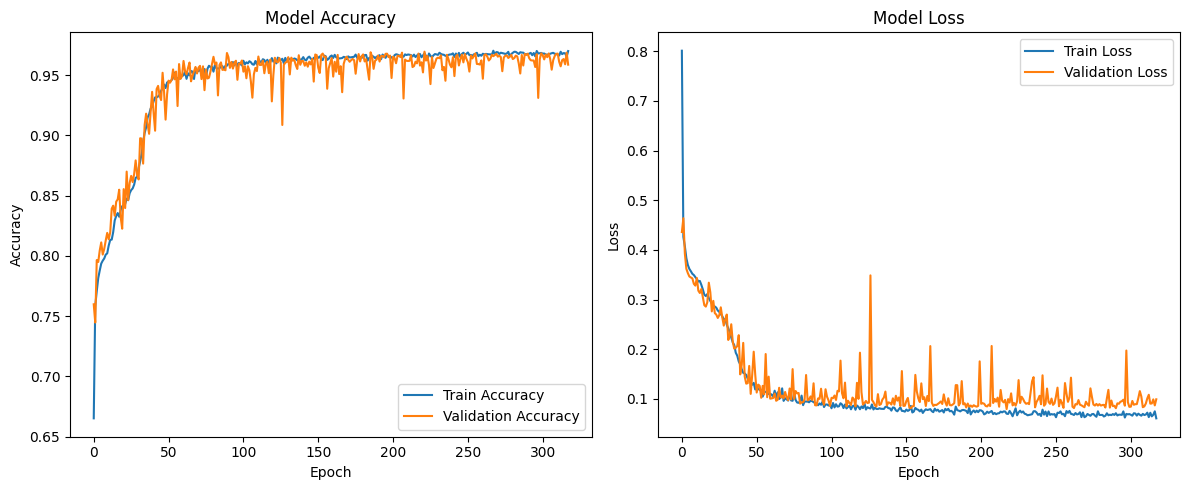

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

# --- Plotting Metrics ---
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="lower right")

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [32]:
from sklearn.metrics import f1_score

# load the best model
from tensorflow.keras.models import load_model

dnn_model = load_model("dnp3_best_model.h5")

# Predict class probabilities for the test set
y_pred_prob = dnn_model.predict(X_test)
# Convert probabilities to class indices
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate macro-averaged F1 score for multi-class classification
f1 = f1_score(y_true, y_pred, average="macro")
acc = accuracy_score(y_true, y_pred)
print(f"F1 Score (macro): {f1:.4f}, Accuracy: {acc:.4f}")

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
F1 Score (macro): 0.9151, Accuracy: 0.9679


#### Torch 

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np


class CustomDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        labels_key: str = "Label",
        split: str = "train",
        random_state: int = 42,
        max_data: int = -1,
        train_size: float = 0.75,
    ):
        self.train_size = train_size
        self.df = df
        class_names = df[labels_key].unique()
        class_names.sort()
        self.class_names = class_names
        self.class_encoder = {name: i for i, name in enumerate(class_names)}

        self.df = self.df.sample(
            frac=1.0, random_state=random_state, replace=False
        ).reset_index(drop=True)

        if max_data > 0:
            self.df = self.df.iloc[:max_data]

        self.labels = self.df[labels_key].values
        self.features = self.df.drop(columns=[labels_key]).values

        self.scaler = MinMaxScaler()
        self.features = self.scaler.fit_transform(self.features)

        self.split = split
        self.random_state = random_state
        self._split_data()
        self._one_hot_encode_labels()

    def _split_data(self):
        if self.split == "train":
            self.features = self.features[: int(len(self.features) * self.train_size)]
            self.labels = self.labels[: int(len(self.labels) * self.train_size)]
        else:
            self.features = self.features[int(len(self.features) * self.train_size) :]
            self.labels = self.labels[int(len(self.labels) * self.train_size) :]

    def _one_hot_encode_labels(self):
        labels = np.zeros((self.labels.shape[0], len(self.class_names)))
        for i, label in enumerate(self.labels):
            labels[i, self.class_encoder[label]] = 1
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if idx == len(self.labels) - 1:
            idxs = np.arange(len(self.labels))
            np.random.shuffle(idxs)
            self.features = self.features[idxs]
            self.labels = self.labels[idxs]

        return torch.from_numpy(self.features[idx]).to(torch.float32), torch.from_numpy(
            self.labels[idx]
        ).to(torch.float32)


df = combined_df.copy()
# df = oversample_class(df, "Label")
max_data = -1
train_dataset = CustomDataset(df, split="train", max_data=max_data)
test_dataset = CustomDataset(df, split="test", max_data=max_data)
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

for features, labels in train_loader:
    print(f"Features: {features.shape}, Labels: {labels.shape}")
    break

Features: torch.Size([32, 95]), Labels: torch.Size([32, 9])


In [34]:
# --- Define the DNN model ---
class DNP3DNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DNP3DNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 90),
            nn.ReLU(),
            nn.Linear(90, 90),
            nn.ReLU(),
            nn.Linear(90, 90),
            nn.ReLU(),
            nn.Linear(90, 90),
            nn.ReLU(),
            nn.Linear(90, 90),
            nn.ReLU(),
            nn.Linear(90, 90),
            nn.ReLU(),
            nn.Linear(90, 90),
            nn.ReLU(),
            nn.Linear(90, 90),
            nn.ReLU(),
            nn.Linear(90, 90),
            nn.ReLU(),
            nn.Linear(90, output_dim),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        return self.net(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

max_data = -100
train_dataset = CustomDataset(df, split="train", max_data=max_data)
test_dataset = CustomDataset(df, split="test", max_data=max_data)
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_dim = train_dataset.features.shape[1]
output_dim = train_dataset.labels.shape[1]
model = DNP3DNN(input_dim, output_dim)
model.to(device)

# --- Training setup ---
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 1000
log_every = 1
# --- Training loop ---
train_losses = []
train_accs = []

test_losses = []
test_accs = []
max_acc = 0.0
max_epoch = 0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    acc = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)

        acc += (
            (torch.argmax(outputs, dim=1) == torch.argmax(labels, dim=1)).float().sum()
        )

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss = running_loss / len(train_loader.dataset)
    acc /= len(train_loader.dataset)
    train_losses.append(loss)
    train_accs.append(acc)

    # --- Evaluation ---
    model.eval()
    running_loss = 0.0
    acc = 0.0
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            acc += (
                (torch.argmax(outputs, dim=1) == torch.argmax(labels, dim=1))
                .float()
                .sum()
            )
    loss = running_loss / len(test_loader.dataset)
    acc /= len(test_loader.dataset)
    if acc > max_acc:
        max_acc = acc
        max_epoch = epoch
        torch.save(model.state_dict(), "dnp3_dnn_best_model.pth")
    test_losses.append(loss)
    test_accs.append(acc)
    if epoch % log_every == 0:
        logger.info(
            f"Epoch [{epoch}/{num_epochs}], "
            f"Train Loss: {loss:.4f}, Train Acc: {acc:.4f}, "
            f"Test Loss: {loss:.4f}, Test Acc: {acc:.4f}, "
            f"Max Acc: {max_acc:.4f} @ {max_epoch} epoch"
        )

2025-05-18 17:43:13.313 | INFO     | __main__:<module>:106 - Epoch [0/1000], Train Loss: 0.0043, Train Acc: 0.7118, Test Loss: 0.0043, Test Acc: 0.7118, Max Acc: 0.7118 @ 0 epoch
2025-05-18 17:43:23.345 | INFO     | __main__:<module>:106 - Epoch [1/1000], Train Loss: 0.0031, Train Acc: 0.7440, Test Loss: 0.0031, Test Acc: 0.7440, Max Acc: 0.7440 @ 1 epoch
2025-05-18 17:43:31.816 | INFO     | __main__:<module>:106 - Epoch [2/1000], Train Loss: 0.0029, Train Acc: 0.7469, Test Loss: 0.0029, Test Acc: 0.7469, Max Acc: 0.7469 @ 2 epoch
2025-05-18 17:43:36.443 | INFO     | __main__:<module>:106 - Epoch [3/1000], Train Loss: 0.0027, Train Acc: 0.7764, Test Loss: 0.0027, Test Acc: 0.7764, Max Acc: 0.7764 @ 3 epoch
2025-05-18 17:43:41.526 | INFO     | __main__:<module>:106 - Epoch [4/1000], Train Loss: 0.0027, Train Acc: 0.7770, Test Loss: 0.0027, Test Acc: 0.7770, Max Acc: 0.7770 @ 4 epoch
2025-05-18 17:43:46.604 | INFO     | __main__:<module>:106 - Epoch [5/1000], Train Loss: 0.0028, Train Ac

KeyboardInterrupt: 

In [37]:
# F1 score
from sklearn.metrics import f1_score

best_model = DNP3DNN(input_dim, output_dim)
best_model.load_state_dict(torch.load("dnp3_dnn_best_model.pth", map_location=device))

f1 = 0.0
acc = 0.0

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = best_model(features)
        acc += (
            (torch.argmax(outputs, dim=1) == torch.argmax(labels, dim=1)).float().sum()
        )
        f1 += f1_score(
            torch.argmax(labels, dim=1).cpu(),
            torch.argmax(outputs, dim=1).cpu(),
            average="macro",
        )

    acc /= len(test_loader.dataset)
    f1 /= len(test_loader.dataset)
    logger.info(f"Test Accuracy: {acc:.4f}")
    logger.info(f"Test F1 Score: {f1:.4f}")

F1 Score: 0.0247
